# In this notebook I implement a Bayesian Neural Net for classification


In [1]:
#%% imports 
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from sklearn import datasets
import numpy as np
import scipy.io as scio
import numpy.random as rng
from theano import tensor as tn
from theano import function
from theano import shared
from theano import scan
from theano.tensor.shared_randomstreams import RandomStreams
import lasagne
from lasagne.updates import adagrad, adam
import matplotlib.pyplot as plt
rng.seed(1)
srng = RandomStreams(seed = 1)
import tensorflow as tf
from scipy.stats import mode

# Build the model class

In [2]:
#%% Bayesian neural net model
class bayesian_neural_net(object):
    def __init__(self, layer_sizes, activationFn = lasagne.nonlinearities.tanh):
        self.layer_sizes = layer_sizes;
        self.dim_weights = zip(self.layer_sizes[0:-1], self.layer_sizes[1:])
        self.dim_biases = self.layer_sizes[1:]
        self.nweights = np.sum([np.prod(self.dim_weights[i]) for i in range(len(self.dim_weights))]);
        self.nbiases = np.sum(self.dim_biases);
        self.X = shared(np.zeros((1,self.layer_sizes[0])))
        self.y = shared(np.zeros((1,self.layer_sizes[-1])))
        self.activationFn = activationFn;
        # proposal distribution of z = f(X), z_i~q_i = N(m_i, exp(tau_i)), i \in {1, .... , m}
        self.mu_z = shared(np.zeros(self.nweights+self.nbiases), 'mu_z');
        self.tau_z = shared(np.zeros(self.nweights+self.nbiases), 'tau_z');
        self.sigma_z = lasagne.nonlinearities.softplus(self.tau_z);
        self.z = self.mu_z + srng.normal(tn.shape(self.sigma_z)) * self.sigma_z; # scale-location transformation
        
    def neural_net(self, z, X):
        layer_sizes = self.layer_sizes;
        dim_weights = self.dim_weights;
        dim_biases = self.dim_biases;
        net = lasagne.layers.InputLayer(shape=(None, dim_weights[0]), input_var=X);
        pt_w = 0;
        pt_b = self.nweights;
        for i in range(len(layer_sizes[1:])):
            pt_w = np.array([0, np.prod(dim_weights[i])]);
            pt_b = np.array([0, dim_biases[i]]);
            W = tn.reshape(z[pt_w[0]:pt_w[1]],  dim_weights[i]  );
            b = z[pt_b[0]:pt_b[1]];
            if i < (len(layer_sizes[1:])-1):
                net = lasagne.layers.DenseLayer(incoming = net, num_units=layer_sizes[i+1],
                                              W = W, b = b,nonlinearity=self.activationFn);
            else:
                net = lasagne.layers.DenseLayer(incoming = net, num_units=layer_sizes[i+1],
                                              W = W, b = b,nonlinearity=lasagne.nonlinearities.softmax);
            pt_w = pt_w+np.prod(dim_weights[i]);
            pt_b = pt_b+dim_biases[i];
                    
        out = lasagne.layers.get_output(net);
        return out
    
    ##### pred_label: returns the label prediction #####
    def pred_label(self, z, X):
        out = self.neural_net(z, X);
        predict = tn.argmax(out, axis = 1);
        return predict
    
     ##### pred_error: returns the prediction error #####
    def pred_error(self, z, X, y):
        predict = self.pred_label(z, X)
        label = tn.argmax(y, axis = 1)
        per_error = tn.sum(abs(predict - label)>0)/(tn.shape(X)[0] + 0.) * 100;
        return per_error
        
    ##### logprior_prob: returns the log prior probability of the latent z #####
    def logprior_prob(self, z):
        """the prior = p(z) = N(0, sI)"""
        s = 1.;
        logprior = - 0.5 / s * ((z**2).sum()) - 0.5 * (tn.shape(z)[0]) * np.log(2*np.pi*s)        
        return logprior;
    
    ##### loglik_prob: returns the log likelihood probability of the latent z #####
    def loglik_prob(self, z, X, y):
        """the log likelihood is bernaulli"""
        out = self.neural_net(z, X);
        # model params
        loglik = ((y * tn.log(out)).sum(axis = 1)).sum(); # 
        return loglik
    
    ##### logjoint_prob: returns the log joint probability (unnormalized posterior) of the latent z #####
    def logjoint_prob(self, z, X, y):
        """ joint probability """
        logjoint = self.loglik_prob(z, X, y) + self.logprior_prob(z);
        return logjoint
    
    ##### logq_prob: returns the log of the proposal probability of the latent z #####
    def logq_prob(self, z):
        """ Mean field proposal distribution which is the same as the posterior approximate"""
        logq =  - 0.5 * tn.sum(((z - self.mu_z)/self.sigma_z)**2) - tn.sum(tn.log(self.sigma_z)) - (tn.shape(z)[0]/2.) * np.log(2. * np.pi);
        return logq   
    
    ##### sample_model: function used to sample from the proposal distribution and return the probability of all model elements #####
    def sample_model(self):
        z = self.z;
        X = self.X;
        y = self.y;
        logprior_prob = self.logprior_prob(z);
        loglik_prob = self.loglik_prob(z, X, y);
        logjoint_prob = self.logjoint_prob(z, X, y);
        logq_prob = self.logq_prob(z);
        return logprior_prob, loglik_prob, logjoint_prob, logq_prob, z


# Load Data

Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/gamalamin/git_local_repository/exploration/data/MNIST/t10k-labels-idx1-ubyte.gz
training data points 55000
testing data points 10000
validation data points 5000
image size is 28 x 28


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


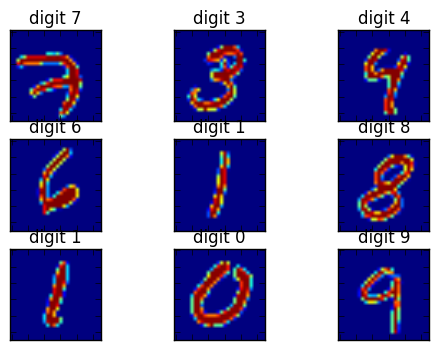

In [3]:
#%% download and store data 
#%% download and store data 
from tensorflow.examples.tutorials import mnist
directory = '/Users/gamalamin/git_local_repository/exploration/'
mnist_data = mnist.input_data.read_data_sets(directory + 'data/MNIST', one_hot=True)
train_data =  mnist_data.train; #{'images': mnist_data.train.images, 'labels': mnist_data.train.labels};
test_data =  mnist_data.test; #{'images': mnist_data.test.images, 'labels': mnist_data.test.labels};
validation_data =  mnist_data.validation; #{'images': mnist_data.validation.images, 'labels': mnist_data.validation.labels};
num_classes = 10;

l = np.sqrt(train_data.images.shape[1]);
digits = np.array(range(num_classes)); # possible digits
"""
data structure:
    mnist_data.train 55,000 training digit images each of size (28 x 28)
    mnist_data.test 10,000 testing images    
    mnist_data.validation 5,000 testing images
"""

print "training data points %d"  %train_data.images.shape[0];
print "testing data points %d"  %test_data.images.shape[0];
print "validation data points %d"  %validation_data.images.shape[0];
print "image size is %d x %d"  %(l, l);

_, axarr= plt.subplots(3,3)
for i in range(9):
    axarr[i/3, i%3].imshow(np.reshape(train_data.images[i, :], (l, l)));
    axarr[i/3, i%3].set_title(('digit %d' %digits[train_data.labels[i, :].astype('bool')]))
    axarr[i/3, i%3].set_xticklabels(' ')
    axarr[i/3, i%3].set_yticklabels(' ')
plt.show('all')

# Build inference

In [4]:
# Initiating a GP classification class
layer_sizes = [int(l**2), 100, num_classes];
mdl = bayesian_neural_net(layer_sizes);
nsamples_vr = tn.scalar(name = 'nsamples_vr', dtype='int32');
## VB_objective 
def onesample():
    logprior_prob, loglik_prob, logjoint_prob, logq_prob, z = mdl.sample_model()
    ELBO =  logjoint_prob - logq_prob;
    g_mu = tn.grad(ELBO, mdl.mu_z)
    g_tau = tn.grad(ELBO, mdl.tau_z)
    predict = mdl.pred_label(mdl.z, test_data.images);
    return  ELBO, g_mu, g_tau, predict 
samples,_ = scan(onesample, n_steps = nsamples_vr);
ELBO = samples[0].mean(axis =0);
mean_g_mu = samples[1].mean(axis =0);
mean_g_tau = samples[2].mean(axis =0);
predict = function(inputs = [nsamples_vr], outputs = samples[3]);

# Training the model

In [5]:
#%% training function
adam_updates = adam([-mean_g_mu, -mean_g_tau], [mdl.mu_z, mdl.tau_z], learning_rate=0.2)
#adagrad_updates = adagrad([-mean_g_mu, -mean_g_tau], [mdl.mu_z, mdl.tau_z], learning_rate=0.001)

trainFn = function(
inputs = [nsamples_vr],
outputs = [ELBO, mdl.pred_error(mdl.z, test_data.images, test_data.labels)],
#updates = adagrad_updates
updates = adam_updates
)


# optimize

In [ ]:
maxiter = 50;
nsamples = 5; # samples from the proposal distribution to calculate E_q[log joint - log q]
ELBO_list = [];
mdl.X.set_value(train_data.images);
mdl.y.set_value(train_data.labels);
for i in range(maxiter):
    out = trainFn(nsamples);
    ELBO_list.append(out[0]);
    print ("prediction error = %.2f %%" %out[1])

prediction error = 90.40 %
prediction error = 78.95 %
prediction error = 80.06 %
prediction error = 77.48 %
prediction error = 84.94 %
prediction error = 70.53 %


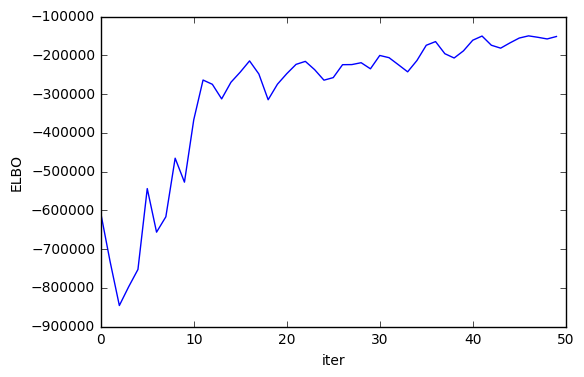

In [7]:
plt.plot(ELBO_list)
plt.xlabel('iter')
plt.ylabel('ELBO')
plt.show()

In [8]:
def sample_pclass():
    return mdl.neural_net(mdl.z, test_data.images)
predict_label = function(inputs = [nsamples_vr], outputs = tn.argmax(tn.mean(scan(sample_pclass, n_steps = nsamples_vr)[0], axis = 0), axis = 1));
label = np.argmax(test_data.labels, axis = 1)
per_error = np.sum(abs(predict_label(50) - label)>0)/(np.shape(test_data.images)[0] + 0.) * 100;


In [9]:
print ("prediction error using p(class) from many sampled networks is %.2f" %per_error)

prediction error using p(class) from many sampled networks is 11.89


In [10]:
mdl.mu_z.set_value(-np.ones(mdl.nweights+mdl.nbiases))
mdl.tau_z.set_value(0.*np.ones(mdl.nweights+mdl.nbiases))

In [11]:
mdl.logprior_prob(mdl.mu_z).eval()

array(-112819.80277510353)

In [12]:
mdl.logq_prob(mdl.mu_z).eval()

array(-43923.36045969973)

In [13]:
mdl.loglik_prob(mdl.mu_z, mdl.X, mdl.y).eval()

array(-126642.18011477518)

In [14]:
mdl.logjoint_prob(mdl.mu_z, mdl.X, mdl.y).eval()

array(-239461.9828898787)